# Prepare ENV/Load libraries

In [ ]:
# !rm -rf tmp && git clone https://github.com/chuan-khuna/my-python-utils.git tmp && cp -R tmp/utils ./ && cp -R tmp/fonts ./ && rm -rf tmp

In [ ]:
!python3 --version

Python 3.8.16


In [ ]:
!pip install matplotlib seaborn -Uq
!pip install pythainlp -q
!pip install keras-tuner -q
!pip install pyYAML -q
!pip install tensorflow-io[tensorflow] tf2onnx onnxruntime -Uq

In [ ]:
%load_ext tensorboard

## Mount Google Drive

In [ ]:
import os
from google.colab import drive

drive.mount('/content/gdrive')
google_drive_path = "/content/gdrive/MyDrive/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# change directory to the project path

project_path = os.path.join(google_drive_path, "Colab Notebooks/SER/")
os.chdir(project_path)
os.listdir("./")

['utils',
 'fonts',
 'meta_data',
 'dataset',
 '.git',
 '.env',
 'config.yml',
 'libs',
 'README.md',
 'models',
 'Notebook Template.ipynb',
 '.gitignore',
 'Preprocess Json to CSV.ipynb',
 'Tensorboard vis.ipynb',
 'HyperParams Tuning Train LSTM.ipynb',
 'Untitled0.ipynb',
 'logs',
 'HyperParams Tuning Train Transformer.ipynb']

# Import Libraries

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
from matplotlib import patheffects
import seaborn as sns

import json
import yaml
import re
from tqdm.notebook import trange, tqdm

import datetime

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import keras_tuner
from tensorflow.keras.layers import *

seed_ = 20200218
tf.random.set_seed(seed_)
np.random.seed(seed_)

from sklearn.metrics import confusion_matrix, classification_report

## Ensure that matplotlib can use subplot mosaic

In [ ]:
def check_version(version_str, major, minor):
    print(version_str)
    version = [int(i) for i in version_str.split('.')]
    assert version[0] >= major and version[1] >= minor

check_version(matplotlib.__version__, 3, 6)
check_version(sns.__version__, 0, 12)

del check_version

matplotlib.__version__, sns.__version__, tf.__version__

3.6.2
0.12.1


('3.6.2', '0.12.1', '2.9.0')

In [ ]:
import tf2onnx
import onnx
import onnxruntime as rt

In [ ]:
import librosa
from librosa.display import specshow
import tensorflow_io as tfio
from IPython.display import Audio

In [ ]:
from utils.vis_utils import *
from libs.audio_preprocessing import AudioPreprocessor

font_dir = [f"{google_drive_path}/code_assets/fonts/"]
mpl_import_fonts(font_dir)

In [ ]:
def get_timestamp():
    timestamp = datetime.datetime.strftime(datetime.datetime.now(), "%Y%m%d-%H%M")
    return timestamp

get_timestamp()

'20221216-0828'

## View hardware spec

In [ ]:
!nvidia-smi

Fri Dec 16 08:28:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    53W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
tf.config.list_physical_devices('GPU')

for device in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(device, True)

## Config Tensorflow precision

In [ ]:
# use mixed precision

policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: float16
Variable dtype: float32


# Load Dataframe

In [ ]:
df = pd.read_csv("./meta_data/dataset.csv")

In [ ]:
# drop emotion label that tagged as None
df = df[df['majority_emo'] != 'None']
df = df[df['majority_emo'] != 'other']
df = df[df['agreement'] >= 0.6]

# shuffle
df = df.sample(frac=1)

In [ ]:
label_col = "majority_emo"

In [ ]:
label_col = "majority_emo"
df = df.join(pd.get_dummies(df[label_col]))

In [ ]:
df

,path,file,assigned_emo,majority_emo,agreement,Angry,Frustrated,Happy,Neutral,Sad
0,./dataset/studio11-20/studio014/con/s014_con_a...,s014_con_actor027_impro2_20.flac,Happy,Frustrated,0.625000,0,1,0,0,0
1,./dataset/studio31-40/studio034/con/s034_con_a...,s034_con_actor108_impro7_8.flac,Frustrated,Frustrated,1.000000,0,1,0,0,0
2,./dataset/studio31-40/studio033/con/s033_con_a...,s033_con_actor105_impro10_17.flac,Angry,Frustrated,0.800000,0,1,0,0,0
3,./dataset/studio21-30/studio025/con/s025_con_a...,s025_con_actor090_impro8_6.flac,Neutral,Frustrated,0.800000,0,1,0,0,0
4,./dataset/zoom1-10/zoom009/mic/z009_mic_actor0...,z009_mic_actor054_script2_2_2a.flac,Angry,Frustrated,0.800000,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
17855,./dataset/studio11-20/studio017/con/s017_con_a...,s017_con_actor034_impro5_5.flac,Sad,Sad,0.875000,0,0,0,0,1
17856,./dataset/zoom11-20/zoom020/mic/z020_mic_actor...,z020_mic_actor075_script1_2_4b.flac,Sad,Sad,1.000000,0,0,0,0,1
17857,./dataset/studio11-20/studio018/con/s018_con_a...,s018_con_actor035_script3_1_3b.flac,Happy,Sad,0.666667,0,0,0,0,1
17858,./dataset/studio31-40/studio035/con/s035_con_a...,s035_con_actor110_script2_1_4a.flac,Sad,Sad,0.600000,0,0,0,0,1


In [ ]:
classes = pd.get_dummies(df[label_col]).columns
num_classes = len(classes)
list(classes)

['Angry', 'Frustrated', 'Happy', 'Neutral', 'Sad']

In [ ]:
class_weight = {}
for i, c in enumerate(list(classes)):
    class_size = (df[label_col] == c).sum()
    class_weight[i] = np.round(1/class_size * len(df)/2.0, 3)

class_weight

{0: 2.5, 1: 2.5, 2: 2.5, 3: 2.5, 4: 2.5}

In [ ]:
# No class_weight

# class_weight = None

In [ ]:
def show_tensor(tensor, take_n=3):
    return list(tensor.take(take_n).as_numpy_iterator())

In [ ]:
def plot_spectrogram(tensor):
    fig = plt.figure(figsize=(9, 3), dpi=100)
    sns.heatmap(tensor.numpy().squeeze())
    plt.show()

# Config Proprocessing process

In [ ]:
img_w, img_h = n_timesteps, n_features = 512, 64

prep = AudioPreprocessor()

prep.img_h = img_h
prep.img_w = img_w
prep.img_ch = 1
prep.nfft = 512
prep.window_length = 512
prep.mel_sr = 44100
prep.n_mels = 128

In [ ]:
setting = prep.__dict__
setting['classes'] = list(classes)
setting['class_weight'] = class_weight
setting

{'nfft': 512,
 'window_length': 512,
 'stride': 256,
 'mel_sr': 44100,
 'n_mels': 128,
 'max_db': 80,
 'img_h': 64,
 'img_w': 512,
 'img_ch': 1,
 'classes': ['Angry', 'Frustrated', 'Happy', 'Neutral', 'Sad'],
 'class_weight': {0: 2.5, 1: 2.5, 2: 2.5, 3: 2.5, 4: 2.5}}

# Load Tensorflow dataset from df

In [ ]:
def load_file_as_spectrogram_map(x, y):
    tensor = prep.from_file(x)
    tensor = prep._normalize(tensor)
    tensor = prep.preprocess(tensor)
    return tensor, y

def preprocess_spectrogram_map(x, y):
    x = tf.transpose(x, perm=[1, 0, 2])
    x = tf.image.resize(x, size=(n_timesteps, n_features))
    return tf.squeeze(x), y

In [ ]:
ds = tf.data.Dataset.from_tensor_slices((df['path'], df[list(classes)]))

ds = ds.map(load_file_as_spectrogram_map)
ds = ds.map(preprocess_spectrogram_map)

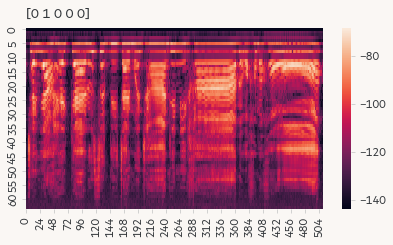

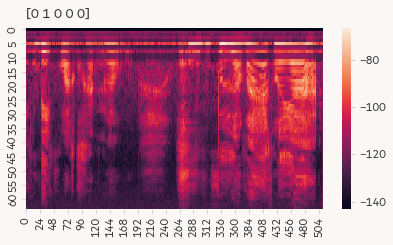

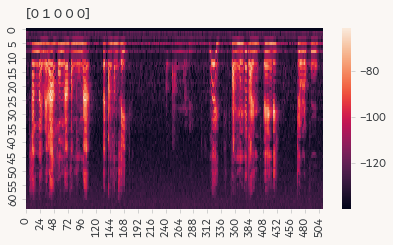

In [ ]:
for x, y in ds.take(3):
    fig = plt.figure(figsize=(6, 3), dpi=80)
    sns.heatmap(x.numpy().T)
    plt.title(str(y.numpy()))
    plt.show()

## Split dataset

In [ ]:
TRAIN_SIZE, VAL_SIZE = 0.7, 0.2

TRAIN_SIZE, VAL_SIZE = int(TRAIN_SIZE*len(df)), int(VAL_SIZE*len(df))
TEST_SIZE = len(df) - (TRAIN_SIZE + VAL_SIZE)
TRAIN_SIZE, VAL_SIZE, TEST_SIZE

(12502, 3572, 1786)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32
SHUFFLE_SIZE = 500

# split train-validation
train_ds = ds.shuffle(SHUFFLE_SIZE, seed=seed_, reshuffle_each_iteration=False).take(TRAIN_SIZE)
val_ds = ds.shuffle(SHUFFLE_SIZE, seed=seed_,
                    reshuffle_each_iteration=False).skip(TRAIN_SIZE).take(VAL_SIZE)
test_ds = ds.shuffle(SHUFFLE_SIZE, seed=seed_,
                     reshuffle_each_iteration=False).skip(TRAIN_SIZE + VAL_SIZE).take(TEST_SIZE)

# prepare to train
train_ds = train_ds.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

# Model

Hypermodel

Search for best batch size

```py
def fit(self, hp, model, *args, **kwargs):

    AUTOTUNE = tf.data.AUTOTUNE
    batch_size = hp.Choice('batch_size', [64, 32, 24, 16, 8])

    data = args[0]
    train_data = data.batch(batch_size).cache().prefetch(AUTOTUNE)

    if 'validation_data' in kwargs.keys():
        val_data = kwargs['validation_data'].batch(batch_size).cache().prefetch(AUTOTUNE)
        kwargs['validation_data'] = val_data
        hist = model.fit(train_data, **kwargs)
    else:
        hist = model.fit(train_data, **kwargs)

    return hist
```

deprecated LSTM hyperparams
```py
lstm_dropout = hp.Choice(f'lstm_{i}_dropout', [0.1, 0.2, 0.25, 0.3, 0.4, 0.5])
rec_act = hp.Choice(f"lstm_{i}_reccurent_act", ['tanh', 'relu', 'leaky_relu', 'gelu'])
act = hp.Choice(f"lstm_{i}_act", ['tanh', 'sigmoid'])

dropout=lstm_dropout
recurrent_dropout=lstm_dropout,
recurrent_activation=rec_act,
activation=act
```

## Transformer Layer

In [ ]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dense_act='relu'):
        super(TransformerBlock, self).__init__()

        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_net = tf.keras.Sequential([tf.keras.layers.Dense(ff_dim, activation=dense_act), 
                                              tf.keras.layers.Dense(embed_dim)])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        out1 = self.layernorm1(inputs + attn_output)
        dense_net_output = self.dense_net(out1)
        return self.layernorm2(out1 + dense_net_output)
    
    def get_config(self):
        config = super().get_config()
        return config

class PositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, seq_length, embed_dim, n=10000):
        super(PositionEmbedding, self).__init__()
        
        # fixed value
        position_embedding_matrix = self.get_positional_embedding(seq_length, embed_dim, n)
        
        self.pos_emb = tf.keras.layers.Embedding(input_dim=seq_length, 
                                                 output_dim=embed_dim,
                                                 weights=[position_embedding_matrix],
                                                 trainable=False)

    def get_positional_embedding(self, seq_length, embed_dim, n):
        pos_embedding = np.zeros((seq_length, embed_dim))

        dim_arr = np.arange(0, embed_dim)
        even_mask = np.array(dim_arr % 2 == 0, int)
        odd_mask = np.array(dim_arr %2 != 0, int)


        for pos_i in range(seq_length):
            # calculate embedding for that position
            even_emb = np.sin(pos_i/n**(2*dim_arr/embed_dim )) * even_mask
            odd_emb = np.cos(pos_i/n**(2*dim_arr/embed_dim )) * odd_mask
            pos_embedding[pos_i] = even_emb + odd_emb

        return pos_embedding

    def call(self, x):
        maxlen = tf.shape(x)[-2]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions

    def get_config(self):
        config = super().get_config()
        return config

In [ ]:
class MyHyperModel(keras_tuner.HyperModel):

    def build(self, hp):
        model = tf.keras.Sequential()

        model.add(InputLayer(input_shape=(n_timesteps, n_features)))

        # Conv1D hyperparams
        for i in range(hp.Int("num_conv1d_layers", 2, 4)):
            filter_size = hp.Choice(f'conv1d_{i}_filters', [256, 128, 96, 64, 32, 24, 16])
            kernel_size = hp.Choice(f'conv1d_{i}_kernel', [3, 4, 5])
            model.add(Conv1D(filter_size, kernel_size))
            model.add(BatchNormalization())
            model.add(MaxPool1D())
        
        # conv as embedding dims, (feature, timestep)
        num_conv_features = model.output.shape[-1]
        num_conv_length = model.output.shape[-2]

        # transformer hyperparams
        tfm_head = hp.Choice(f'transformer_head', [4, 6, 8, 12, 16])
        tfm_dense = hp.Choice(f'transformer_dense', [16, 24, 32, 64])
        tfm_dense_act = hp.Choice(f"transformer_dense_act", ['tanh', 'leaky_relu', 'relu', 'gelu'])

        # positional embedding layer
        # combine with Conv
        if hp.Choice("use_position_embedding", [True, False]):
            pos_embedding = PositionEmbedding(num_conv_length, num_conv_features)
            model.add(pos_embedding)

        # Transformer layer
        transformer_block = TransformerBlock(num_conv_features, tfm_head, tfm_dense, tfm_dense_act)
        model.add(transformer_block)
        transformer_block = TransformerBlock(num_conv_features, tfm_head, tfm_dense, tfm_dense_act)
        model.add(transformer_block)
        
        model.add(GlobalAveragePooling1D())

        # Dense layers Hyperparams
        for i in range(hp.Int("num_dense_layers", 2, 5)):
            act = hp.Choice(f"dense_{i}_act", ['tanh', 'leaky_relu', 'relu', 'gelu'])
            dense_unit_sizes = hp.Choice(f'dense_{i}_units', [128, 96, 64, 32, 24, 16, 8])
            model.add(Dense(dense_unit_sizes))
            if act != 'linear':
                model.add(Activation(act))
            dropout = hp.Choice(f'dropout_{i}', [True, False])
            if dropout:
                dense_dropout = hp.Choice(f'dense_{i}_dropout', [0.2, 0.25, 0.3, 0.4, 0.5])
                model.add(Dropout(dense_dropout))

        # output layer
        model.add(Dense(num_classes, activation="softmax", dtype='float32'))

        learning_rate = hp.Choice(f'lr', [0.001, 1e-4, 1e-5])
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0),
            loss="categorical_crossentropy",
            metrics=["accuracy"]
        )

        return model

    def fit(self, hp, model, *args, **kwargs):

        hist = model.fit(*args, **kwargs)

        return hist

# Tuner

basic tuner

```py
# or BayesianOptimization
tuner = keras_tuner.RandomSearch(
    MyHyperModel(),
    objective="val_accuracy",
    max_trials=4,
    executions_per_trial=1,
    seed=seed_,
    overwrite=True,
    directory="logs/tuner",
    project_name="tune_hypermodel",
)
```

In [ ]:
!rm -rf logs/tuner_tb_logs/

In [ ]:
tuner_tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/tuner_tb_logs/", histogram_freq=1)

In [ ]:
tuner = keras_tuner.Hyperband(
    MyHyperModel(),
    objective="val_accuracy",
    max_epochs=4,
    hyperband_iterations=2,
    seed=seed_,
    overwrite=True,
    directory="logs/tuner",
    project_name="tune_hypermodel",
)

# tuner = keras_tuner.RandomSearch(
#     MyHyperModel(),
#     objective="val_accuracy",
#     max_trials=8,
#     executions_per_trial=1,
#     seed=seed_,
#     overwrite=True,
#     directory="logs/tuner",
#     project_name="tune_hypermodel",
# )

In [ ]:
if class_weight:
    tuner.search(train_ds, epochs=8, validation_data=val_ds,
                 class_weight=class_weight, callbacks=[tuner_tensorboard], verbose=2)
else:
    tuner.search(train_ds, epochs=8, validation_data=val_ds, callbacks=[tuner_tensorboard], verbose=2)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
3                 |?                 |num_conv1d_layers
96                |?                 |conv1d_0_filters
4                 |?                 |conv1d_0_kernel
96                |?                 |conv1d_1_filters
3                 |?                 |conv1d_1_kernel
12                |?                 |transformer_head
64                |?                 |transformer_dense
relu              |?                 |transformer_dense_act
1                 |?                 |use_position_embedding
3                 |?                 |num_dense_layers
leaky_relu        |?                 |dense_0_act
64                |?                 |dense_0_units
0                 |?                 |dropout_0
0.4               |?                 |dense_0_dropout
relu              |?                 |dense_1_act
96                |?                 |dense_1_units
1                 |?                 |dropout_1
0.2  

KeyboardInterrupt: ignored

# Retrain best model

In [ ]:
best_hp = tuner.get_best_hyperparameters()[0]
best_hp.values

In [ ]:
if not os.path.exists("./models/"):
    os.makedirs("./models/", exist_ok=True)

In [ ]:
# !rm -rf logs/tb_logs

## Build top n best models

In [ ]:
def my_model_report(hist,
                    metrics,
                    labels_dict,
                    conf_ticks,
                    fig_title="",
                    save_path="",
                    row_h=2.5,
                    dpi=100):

    # extract metrics in tensorflow's hist obj
    metrics_in_hist = []
    for k in hist.history.keys():
        if not k.startswith('val_'):
            metrics_in_hist.append(k)
    metrics = [metric for metric in metrics if metric in metrics_in_hist]

    # create plot template
    fig_h = (len(metrics) + 1) * row_h
    conf_mosaic = [['conf_train', 'conf_val', 'conf_test']]
    fig_mosaic = [[metric] * 3 for metric in metrics]
    fig, axs = plt.subplot_mosaic(fig_mosaic + conf_mosaic, figsize=(fig_h, fig_h), dpi=dpi)

    plt.suptitle(fig_title)

    # plot epoch history
    epochs = hist.epoch
    for metric in metrics:
        sns.lineplot(x=epochs, y=hist.history[metric], label=metric, ax=axs[metric])

        val_metric = 'val_' + metric
        if val_metric in hist.history.keys():
            sns.lineplot(x=epochs, y=hist.history[val_metric], label=val_metric, ax=axs[metric])
            axs[metric].grid(True, alpha=0.2)

    # plot confusion matrix
    valid_keys = ['train', 'val', 'test']
    for k in list(labels_dict.keys()):
        if k in valid_keys:
            data = labels_dict[k]
            if 'true' in list(data.keys()) and 'pred' in list(data.keys()):
                true_labels = data['true']
                pred_labels = data['pred']
                sns.heatmap(confusion_matrix(true_labels, pred_labels),
                            annot=True,
                            fmt='d',
                            square=True,
                            cbar=False,
                            ax=axs[f'conf_{k}'],
                            xticklabels=conf_ticks,
                            yticklabels=conf_ticks)
                axs[f'conf_{k}'].set_title(f'confusion matrix {k}')

    for k in valid_keys:
        if k not in list(labels_dict.keys()):
            axs[f'conf_{k}'].axis('off')

    axs['conf_train'].set_title('confusion matrix train')
    axs['conf_train'].set_xlabel('pred')
    axs['conf_train'].set_ylabel('actual')

    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=200)
    plt.show()

In [ ]:
def train_hypermodel(hypermodel, hp, model, epochs, class_weight, timestamp):

    log_dir = os.path.join("logs/tb_logs", timestamp)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    monitoring_metric = 'val_loss'
    metric_delta = 0.001
    early_stop = tf.keras.callbacks.EarlyStopping(monitor=monitoring_metric,
                                                patience=32,
                                                min_delta=metric_delta)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor=monitoring_metric,
                                                    patience=24,
                                                    min_delta=metric_delta,
                                                    cooldown=16,
                                                    min_lr=1e-8)
    checkpoint_filepath = f'./models/{timestamp}/checkpoint'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath,
                                                    monitor=monitoring_metric,
                                                    save_best_only=True)

    callbacks = [tensorboard_callback, early_stop, reduce_lr, checkpoint]
    
    if class_weight:
        hist = hypermodel.fit(hp,
                          model,
                          train_ds,
                          epochs=epochs,
                          validation_data=val_ds,
                          callbacks=callbacks,
                          class_weight=class_weight, verbose=2)
    else:
        hist = hypermodel.fit(hp,
                            model,
                            train_ds,
                            epochs=epochs,
                            validation_data=val_ds,
                            callbacks=callbacks, verbose=2)

    model.save(f'./models/{timestamp}/final')

    tf.keras.utils.plot_model(model, show_shapes=True, to_file=f"./models/{timestamp}/model_arch.png")

    with open(f"./models/{timestamp}/preprocess.json", "w") as f:
        f.write(json.dumps(setting, indent=2, ensure_ascii=False))


    train_labels = [label for x, label in (train_ds.take(-1).as_numpy_iterator())]
    val_labels = [label for x, label in (val_ds.take(-1).as_numpy_iterator())]
    test_labels = [label for x, label in (test_ds.take(-1).as_numpy_iterator())]

    train_labels = np.argmax(np.concatenate(train_labels), axis=-1)
    val_labels = np.argmax(np.concatenate(val_labels), axis=-1)
    test_labels = np.argmax(np.concatenate(test_labels), axis=-1)

    pred_train_labels = np.argmax(model.predict(train_ds), axis=-1)
    pred_val_labels = np.argmax(model.predict(val_ds), axis=-1)
    pred_test_labels = np.argmax(model.predict(test_ds), axis=-1)

    metrics = ['loss', 'accuracy']

    labels_dict = {
        'train': {
            'true': train_labels,
            'pred': pred_train_labels
        },
        'val': {
            'true': val_labels,
            'pred': pred_val_labels
        },
        'test': {
            'true': test_labels,
            'pred': pred_test_labels
        }
    }

    ticks = classes

    fig_title = f"{timestamp} | {len(train_labels)}/{len(val_labels)}/{len(test_labels)}"
    save_path = f"./models/{timestamp}.jpg"

    my_model_report(hist,
                    metrics,
                    labels_dict,
                    ticks,
                    fig_title=fig_title,
                    save_path=save_path,
                    row_h=3.5)


In [ ]:
TRAIN_EPOCHS = 256

In [ ]:
top_n_models = 3

for i in range(0, top_n_models):

    best_hp = tuner.get_best_hyperparameters(top_n_models)[i]
    print(best_hp.values)

    hypermodel = MyHyperModel()
    model = hypermodel.build(best_hp)
    print(model.summary())

    timestamp = get_timestamp()

    train_hypermodel(hypermodel, best_hp, model, TRAIN_EPOCHS, class_weight, timestamp)

In [ ]:
%tensorboard --logdir logs/tuner_tb_logs/

In [ ]:
%tensorboard --logdir logs/tb_logs